**Chatbot**

Chatbot is a computer program designed to simulate conversation with human users especially over the internet.

Here I have developed Chatbot using general conversation between human and computer.

**1 Import requried model**

In [ ]:
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
nltk.download("punkt")
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
from nltk.corpus import stopwords
nltk.download("stopwords")

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence #unique id

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout, Embedding
from keras.callbacks import EarlyStopping, ModelCheckpoint

import nlp_utils as nu

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df = open("/content/drive/MyDrive/dialogs.txt")
print(df.read())

In [ ]:
# Reading text file
text_data = pd.read_table("/content/drive/MyDrive/dialogs.txt",names=('Query','Response'))
text_data.head(10)

**2 EDA**

In [ ]:
text_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3725 entries, 0 to 3724
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Query     3725 non-null   object
 1   Response  3725 non-null   object
dtypes: object(2)
memory usage: 58.3+ KB


In [ ]:
# Finding Null value
text_data.isna().sum()

Query       0
Response    0
dtype: int64

In [ ]:
# Removing all row which have blank space in it
blank = []
for i ,qu , rs in text_data.itertuples():
  if type(qu) == str:
    if qu.isspace():
      blank.append(i)
blank

[]

In [ ]:
# Checking count value present in Query column
text_data["Query"].value_counts()

what do you mean?                              22
why not?                                       16
what happened?                                 10
why is that?                                    9
me too.                                         7
                                               ..
you can yell at them.                           1
and they will yell back at you.                 1
yelling doesn't do any good.                    1
will you look at this form?                     1
but i do all my writing with my right hand.     1
Name: Query, Length: 3510, dtype: int64

In [ ]:
# Checking count value present in Response column
text_data["Response"].value_counts()

what do you mean?                                                       22
why not?                                                                16
what happened?                                                          10
why is that?                                                             9
of course.                                                               8
                                                                        ..
i don't understand some things.                                          1
let me help you.                                                         1
what does "mi" mean?                                                     1
mi stands for middle initial.                                            1
start typing instead. that way your left hand will do half the work.     1
Name: Response, Length: 3512, dtype: int64

**3 Visualization** 

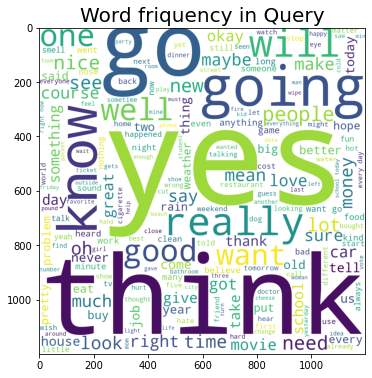

In [ ]:
#Word Cloud is data visualization technique used to represent text data in which size of word shows its frequency of occurancy
from wordcloud import WordCloud

#Creating an object
wc = WordCloud(width = 1200, height = 1200, background_color= "white")

wc.generate("".join(text_data["Query"]))

plt.figure(figsize = (6,6))

plt.title("Word friquency in Query", fontsize = 20)

plt.imshow(wc)

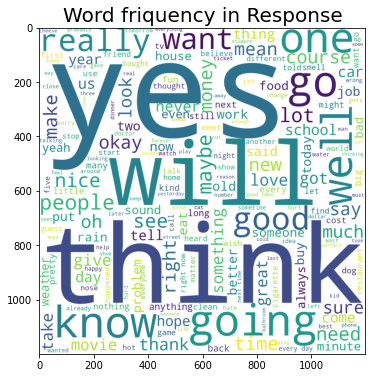

In [ ]:
# Worldword for response dataset
wc.generate("".join(text_data["Response"]))

plt.figure(figsize = (6,6))

plt.title("Word friquency in Response", fontsize = 20)

plt.imshow(wc)

In [ ]:
# Collectig all word from Query collumn
Query_carpus =[]
for msg in text_data["Query"].tolist():
  for word in msg.split():
    Query_carpus.append(word)

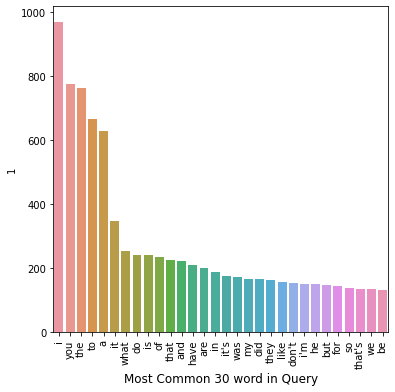

In [ ]:
# Counter will count number of time word is present in the text
from collections import Counter

plt.figure(figsize = (6,6))

#Plotting barplot of top most 30 word 
sns.barplot(pd.DataFrame(Counter(Query_carpus).most_common(30))[0],pd.DataFrame(Counter(Query_carpus).most_common(30))[1])

plt.xlabel("Most Common 30 word in Query",fontsize = 12)
plt.xticks(rotation='vertical')
plt.show()

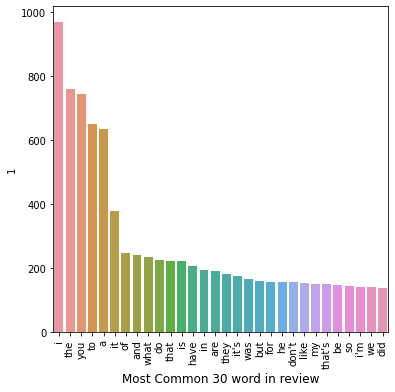

In [ ]:
Resp_carpus =[]
for msg in text_data["Response"].tolist():
  for word in msg.split():
    Resp_carpus.append(word)


from collections import Counter

plt.figure(figsize = (6,6))

#Plotting barplot of top most 30 word
sns.barplot(pd.DataFrame(Counter(Resp_carpus).most_common(30))[0],pd.DataFrame(Counter(Resp_carpus).most_common(30))[1])

plt.xlabel("Most Common 30 word in review", fontsize =12)

plt.xticks(rotation='vertical')

plt.show()

**4 Cleaning Text**

In [ ]:
from nltk.tokenize import word_tokenize
# Function for cleaning the text
def Cleantext(text):

  #step1
  #Convert text into word token
  token = word_tokenize(text.lower())

  #step2 
  # filter only alphanumeric value
  atoken =[word for word in token if(word.isalpha())]

  #step3
  # Removing all stop words
  #stoken =[word for word in atoken if word not in stopwords.words("english")]

  #Step 4
  # Converting word into root word with it's proper meaning 
  lemm = WordNetLemmatizer()
  ltoken = [lemm.lemmatize(word) for word in atoken]

  return " ".join(ltoken)

sent = "Hello how are you kiran"
Cleantext(sent)

'hello how are you kiran'

In [ ]:
#Clean the complet data
text_data["Query"] = text_data["Query"].apply(Cleantext) 

In [ ]:
text_data.head()

,Query,Response
0,hi how are you doing,i'm fine. how about yourself?
1,i fine how about yourself,i'm pretty good. thanks for asking.
2,i pretty good thanks for asking,no problem. so how have you been?
3,no problem so how have you been,i've been great. what about you?
4,i been great what about you,i've been good. i'm in school right now.


**5 Feature Engineering**

In [ ]:
# Sentiment Intensity analyser
nltk.download("vader_lexicon") 

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Creating an object
sid = SentimentIntensityAnalyzer()
#sid.polarity_scores()

In [ ]:
# Check Polarity of text in query column
def PolarityScore(text):

   score = sid.polarity_scores(text)

   score_value = score["compound"]

   return score_value

In [ ]:

text_data["Score"] = text_data["Query"].apply(PolarityScore)

In [ ]:
text_data.head(10)

,Query,Response,Score
0,hi how are you doing,i'm fine. how about yourself?,0.0000
1,i fine how about yourself,i'm pretty good. thanks for asking.,0.2023
2,i pretty good thanks for asking,no problem. so how have you been?,0.8402
3,no problem so how have you been,i've been great. what about you?,-0.5994
4,i been great what about you,i've been good. i'm in school right now.,0.6249
5,i been good i in school right now,what school do you go to?,0.4404
6,what school do you go to,i go to pcc.,0.0000
7,i go to pcc,do you like it there?,0.0000
8,do you like it there,it's okay. it's a really big campus.,0.3612
9,it okay it a really big campus,good luck with school.,0.2263


In [ ]:
def Label_data(Score):

  if Score > 0.5:
    # Positive Score
    return "pos"
  else:
    #Negative
    return "neg"
  

In [ ]:
text_data["Label"] = text_data["Score"].apply(Label_data) 

In [ ]:
text_data.head()

,Query,Response,Score,Label
0,hi how are you doing,i'm fine. how about yourself?,0.0000,neg
1,i fine how about yourself,i'm pretty good. thanks for asking.,0.2023,neg
2,i pretty good thanks for asking,no problem. so how have you been?,0.8402,pos
3,no problem so how have you been,i've been great. what about you?,-0.5994,neg
4,i been great what about you,i've been good. i'm in school right now.,0.6249,pos


**Model Building**

In [ ]:
#Label Encoding
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
text_data["Label"] = lb.fit_transform(text_data["Label"])

In [ ]:
# Spliting the data
X = text_data["Query"]
Y = text_data["Label"]


In [ ]:
# Apply train test split on X and Y variable
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.3, random_state=1)

In [ ]:
# Counting number of word in each sentence
sentlen = []
for sent in text_data["Query"]:
  sentlen.append(len(word_tokenize(sent)))

text_data["Sentlen"] = sentlen
text_data.head()


,Query,Response,Score,Label,Sentlen
0,hi how are you doing,i'm fine. how about yourself?,0.0000,0,5
1,i fine how about yourself,i'm pretty good. thanks for asking.,0.2023,0,5
2,i pretty good thanks for asking,no problem. so how have you been?,0.8402,1,6
3,no problem so how have you been,i've been great. what about you?,-0.5994,0,7
4,i been great what about you,i've been good. i'm in school right now.,0.6249,1,6


In [ ]:
text_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3725 entries, 0 to 3724
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Query     3725 non-null   object 
 1   Response  3725 non-null   object 
 2   Score     3725 non-null   float64
 3   Label     3725 non-null   int64  
 4   Sentlen   3725 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 145.6+ KB


In [ ]:
# Maxinum length of sentence
max(sentlen)

19

In [ ]:
# 95% of sentence length is 11 
max_len = np.quantile(sentlen, 0.95)
max_len

11.0

In [ ]:
# Tokenize sentence word level
tok = Tokenizer(char_level = False , split = " ")

tok.fit_on_texts(xtrain)

In [ ]:
vocab_len = len(tok.index_word)
vocab_len

1773

In [ ]:
# Converting text to sequences
seqtrain = tok.texts_to_sequences(xtrain)

In [ ]:
# Converting text into unqiue value vector
seqmatrain = sequence.pad_sequences(seqtrain, truncating='post',maxlen= int(max_len))
seqmatrain

array([[   0,    0,    0, ...,   78,  112,   58],
       [   0,    0,    0, ...,    9,    2,   11],
       [   0,    0,    0, ...,    1,   35,   28],
       ...,
       [   0,    1,  326, ...,  867,   49,   58],
       [   0,    0,    0, ...,    2,  168,   84],
       [   0,    0,    0, ...,  230,   15, 1021]], dtype=int32)

In [ ]:
# Converting text into unqiue value vector
seqtest = tok.texts_to_sequences(xtest)
seqmatest = sequence.pad_sequences(seqtest,truncating="post",maxlen= int(max_len))
seqmatest

array([[   0,    0,    0, ..., 1172,   55,   17],
       [   0,    0,    0, ...,   93,    1,   22],
       [   0,    0,  105, ...,    3,  396,  434],
       ...,
       [   0,    0,    0, ...,    1,   41,    3],
       [   0,    0,    0, ...,   18,   48,  109],
       [   0,    0,    0, ...,   96,   93,    4]], dtype=int32)

In [ ]:
# Design a model which will predict query is positive or negative
lstm = Sequential()

lstm.add(Embedding(vocab_len+1,16, input_length=int(max_len), mask_zero=True))

lstm.add(LSTM(units=16, activation="relu"))

lstm.add(Dense(units=16, activation="relu"))

lstm.add(Dropout(0.2))

lstm.add(Dense(units=1, activation="sigmoid"))

lstm.compile(loss = "binary_crossentropy",optimizer="adam",metrics=["accuracy"])


In [ ]:
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 11, 16)            28384     
                                                                 
 lstm (LSTM)                 (None, 16)                2112      
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 30,785
Trainable params: 30,785
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm.fit(seqmatrain, np.array(ytrain) ,batch_size=50, epochs=100)


In [ ]:
query = tok.texts_to_sequences(text_data["Query"])
query = sequence.pad_sequences(query , maxlen= int(max_len))

In [ ]:

ypred = lstm.predict(query)

ypred = ypred>0.5
text_data["Model_label"] = ypred


In [ ]:
text_data["Model_label"] = text_data["Model_label"].replace(False, "neg")
text_data["Model_label"] = text_data["Model_label"].replace(True , "pos")

In [ ]:
#Creating dependent column by using sentiment analysis
text_data.head(10)

,Query,Response,Score,Label,Sentlen,Model_label
0,hi how are you doing,i'm fine. how about yourself?,0.0000,0,5,neg
1,i fine how about yourself,i'm pretty good. thanks for asking.,0.2023,0,5,neg
2,i pretty good thanks for asking,no problem. so how have you been?,0.8402,1,6,pos
3,no problem so how have you been,i've been great. what about you?,-0.5994,0,7,neg
4,i been great what about you,i've been good. i'm in school right now.,0.6249,1,6,pos
5,i been good i in school right now,what school do you go to?,0.4404,0,8,neg
6,what school do you go to,i go to pcc.,0.0000,0,6,neg
7,i go to pcc,do you like it there?,0.0000,0,4,neg
8,do you like it there,it's okay. it's a really big campus.,0.3612,0,5,neg
9,it okay it a really big campus,good luck with school.,0.2263,0,7,neg


In [ ]:
#Confution matrix tell us number of correct predicted value by over model
from sklearn.metrics import confusion_matrix
confusion_matrix(ytest,ypred) 

array([[988,  19],
       [ 46,  65]])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1007
           1       0.77      0.59      0.67       111

    accuracy                           0.94      1118
   macro avg       0.86      0.78      0.82      1118
weighted avg       0.94      0.94      0.94      1118



In [ ]:
text_data.head(20)

,Query,Response,Score,Label,Sentlen
0,hi how are you doing,i'm fine. how about yourself?,0.0000,0,5
1,i fine how about yourself,i'm pretty good. thanks for asking.,0.2023,0,5
2,i pretty good thanks for asking,no problem. so how have you been?,0.8402,1,6
3,no problem so how have you been,i've been great. what about you?,-0.5994,0,7
4,i been great what about you,i've been good. i'm in school right now.,0.6249,1,6
5,i been good i in school right now,what school do you go to?,0.4404,0,8
6,what school do you go to,i go to pcc.,0.0000,0,6
7,i go to pcc,do you like it there?,0.0000,0,4
8,do you like it there,it's okay. it's a really big campus.,0.3612,0,5
9,it okay it a really big campus,good luck with school.,0.2263,0,7


**Designing Chatbot**

In [ ]:
# Dialog dataset
text_data.head()

,Query,Response,Score,Label,Sentlen
0,hi how are you doing,i'm fine. how about yourself?,0.0000,0,5
1,i fine how about yourself,i'm pretty good. thanks for asking.,0.2023,0,5
2,i pretty good thanks for asking,no problem. so how have you been?,0.8402,1,6
3,no problem so how have you been,i've been great. what about you?,-0.5994,0,7
4,i been great what about you,i've been good. i'm in school right now.,0.6249,1,6


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
vectorizer = TfidfVectorizer()
factors = vectorizer.fit_transform(text_data['Query']).toarray()

In [ ]:
from sklearn.metrics.pairwise import cosine_distances

In [ ]:

def Chatbot(query):

  # Clean the query
  query = Cleantext(query)
  print()
  # step:-2 word embedding - transform
  query_vector = vectorizer.transform([query]).toarray()

  # step-3: cosine similarity
  similar_score = 1 -cosine_distances(factors,query_vector)

   # take max index position
  index = similar_score.argmax()

  # searching or matching question
  matching_question = text_data.loc[index]['Query']

  response = text_data.loc[index]['Response']

  confidence = similar_score[index][0]

  char_dict ={  'match':matching_question,
                'response':response,
                'score':confidence}
  return char_dict


In [ ]:
print("     Wellcome, Here is Chatterbot  ")
while True:
    query = input('USER: ')
    if query == 'exit':
        break 
    response = Chatbot(query)

    if response['score'] <= 0.2: # 
        print('BOT: Please rephrase your Question.')

    else:
      print('BOT: ',response['response'])
      print("=" *80)

     Wellcome, Here is Chatterbot
USER: hi how are you doing

BOT:  i'm fine. how about yourself?
USER: i'm pretty good. thanks for asking.

BOT:  no problem. so how have you been?
USER: what school do you go to?

BOT:  i go to pcc.
USER: do you like it there?	

BOT:  it's okay. it's a really big campus.
USER: good luck with school.

BOT:  thank you very much.
USER: exit


--------------------------END of Project....................